## OVERVIEW
---
* Image Preprocessing with OpenCV
    * Masking
    * Segmentation
    * Image Sharpening
* Transfer Learning with Keras Pretrained Model
* Feature Extraction
* Deep Learning Model to Classify the Images

In [1]:
#para manejo de datos
import numpy as np
#para manejo de arreglos y tablas
import pandas as pd

#para gráficas
import matplotlib.pyplot as plt
#para gráficas más complejas
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

#para funciones del sistema operativo
import os
#para el modelo xception CNN
from keras.applications import xception
#para el procesamiento de imagenes
from tensorflow.keras.preprocessing import image
#para dividir los datos
from sklearn.model_selection import train_test_split
#para las métricas de desempeño
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#para visión por computadora y procesamiento de imágenes
import cv2

#para agregar barras de progreso en las iteraciones
from tqdm import tqdm

#para el modelo de ML
from keras.models import Sequential
from keras.layers import Dense

#para utilizar comandos de python
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#copia el modelo preentrenado "xception" al directorio cache
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copia el modelo "xception"
#!copy ../input/keras-pretrained-models/xception* ~/.keras/models/

In [3]:
data_folder = './fire_dataset'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [4]:
#para guardar las etiquetas
image_count = {}
#para guardar los directorios y categorias
train_data = []

#guarda las etiquetas en image_count, luego guarda directorios y categorías en train_data
for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 86.96it/s]


In [5]:
#muestra los datos en image_count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 3206
non_fire_images -> 4088


In [6]:
#crea un dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(7294, 3)

file  id        label
0     fire_images/fire (1).jpg   0  fire_images
1  fire_images/fire (1001).jpg   0  fire_images
2  fire_images/fire (1002).jpg   0  fire_images
3  fire_images/fire (1003).jpg   0  fire_images
4  fire_images/fire (1004).jpg   0  fire_images

### IMAGE PREPROCESSING

In [7]:
#para aplicar máscaras
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    #utiliza una máscara para convertir la imagen a formato de color hsv
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    #estructura los arreglos (imagenes) para que funcionen en elipses
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    #rellena partes de la imágen para que sea más clara
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#para hacer segmentación
def segment_image(image):
    mask = create_mask_for_plant(image)
    #combina dos imagenes
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#para hacer un "sharpen"
def sharpen_image(image):
    #se hace más suave la imágen
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    #se hace una combinación entre la imagen suave y la inicial
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

#para obtener una imagen
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convierte una imagen a arreglo
    img = image.img_to_array(img)
    return img

### SHOW SAMPLE IMAGES

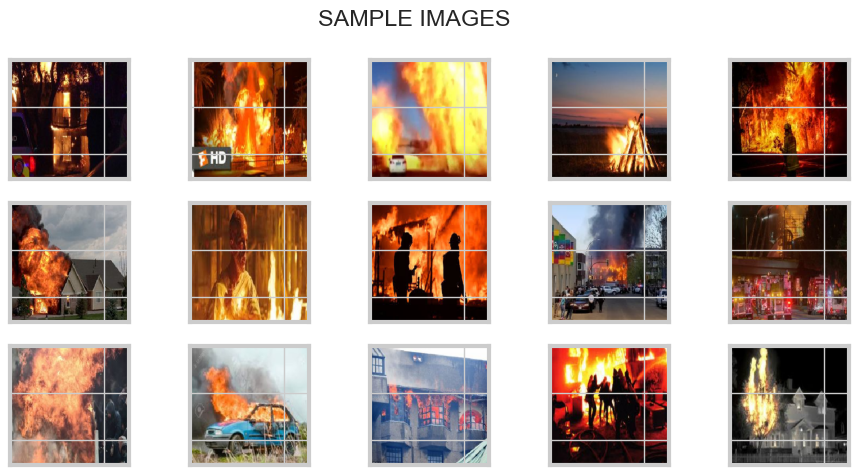

In [8]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

### SHOW SAMPLE PROCESSED IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


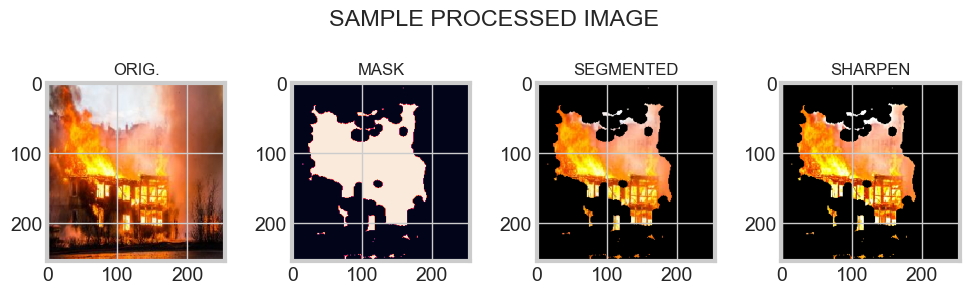

In [9]:
#se obtiene la imagen
img = read_img(df['file'][56],(255,255))
#aplica mascara
image_mask = create_mask_for_plant(img)
#aplica segmentacion
image_segmented = segment_image(img)
#aplica sharpen
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);



### XCEPTION BOTTLENECK FEATURE EXTRACTION

In [10]:
INPUT_SIZE=255

#preprocesa la entrada
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #lee la imagen
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #mascara y segmentacion
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    #se expande la imagen "sharpen" dentro de cada fila de un arreglo
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

7294it [00:44, 163.20it/s]


In [11]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (7294, 255, 255, 3)
Train Image Size:  1422877050


#### SPLIT THE DATA

In [ ]:
y = df['id']
#divide los datos en entrenamiento y prueba (según test_size)
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.3, random_state=101)

In [ ]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

In [ ]:
#se obtienen las caracteristicas
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

In [ ]:
#imprime las caracteristicas en entrenamiento y prueba
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

### DEEP LEARNING MODEL

In [ ]:
#modelo secuencial de RNA
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
#entrena el modelo con 100 epocas
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

#### LOSS AND ACCURACY

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [ ]:
#predecir los datos de validación
predictions = (model.predict(bf_train_val) > 0.5).astype("int32")

#### CLASSIFICATION REPORT

In [ ]:
#precision: predicciones positivas correctas/predicciones correctas totales
#recall: predicciones positivas correctas/positivos reales
#f1: promedio entre precision y recall
print(classification_report(y_val, predictions))

#### CONFUSION MATRIX

In [ ]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

In [ ]:
model.save("modelo_chido.h5")